# N-Gram model to cluster code into clusters

This model was based on [Kristian Wahlroos's](https://github.com/wakr/MSc-Thesis) MSc research and source code to prototype a n-gram based modeling, used for plagiarism detection, to instead just return the clusters as is.


In [1]:
import numpy as np
import pandas as pd
import scipy
import psycopg2

import matplotlib.pyplot as plt

import os
import json

In [2]:
def parse_testdata(path='../data/rainfall-submissions.tsv'):
    file = open(path,'r')
    raw = file.readlines()
    file.close()
    res = dict()
    exid = "3c79c115-0f5f-4d8e-b02c-b4b33155a4b3"
    get_code = lambda data: data["mooc-2017-ohjelmointi"]["osa02-Osa02_16.MarsinLampotilanKeskiarvo"]["/src/MarsinLampotilanKeskiarvo.java"]
    for line in raw:
        id = line[:len(exid)]
        body = json.loads(line[len(exid):])
        res[id] = get_code(body)
    return res

rain = parse_testdata()

In [3]:
import re

def normalize(source_code):
    res = re.sub("import.*;", "", source_code)
    res = re.sub("\".+\"", "\"\"", res)
    res = re.sub("\t+", "", res)
    res = re.sub("\n", "", res)
    res = re.sub("\s+", " ", res)
    res = re.sub("({|})", " ", res)
    res = re.sub("\d+", "t0", res)
    res = re.sub("(for|while)", "loop", res)
    return res

def normalize_for_ai(source_code):
    res = re.sub("\/\*.*\*\/", "", source_code, flags=re.DOTALL) # multiline comment
    res = re.sub("\/\/.*", "", res) # inline comments
    res = re.sub("\".+\"", "\"\"", res) # string values
    res = re.sub("\d+", "$", res)
    return res

def normalize_for_ast(source_code):
    res = re.sub("import.*;", "", source_code)
    res = re.sub("package.*;", "", res)
    return res


In [5]:
import antlr4
from antlr_local.JavaLexer import JavaLexer
from antlr_local.JavaParser import JavaParser
from antlr_local.JavaParserListener import JavaParserListener
from MyListener import KeyPrinter
import pprint

from antlr4 import RuleContext

import glob

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

def parse_to_compositional_tokens(code):
    #print("parsing: ", self.ID)
    code_stream = antlr4.InputStream(code)
    lexer = JavaLexer(code_stream)
    token_stream = antlr4.CommonTokenStream(lexer)
    parser = JavaParser(token_stream)
    tree = parser.compilationUnit()

    printer = KeyPrinter()
    walker = antlr4.ParseTreeWalker()
    walker.walk(printer, tree)

    return printer.get_result()

def parse_data(codeDict):
    ids = list(codeDict.keys())
    token_list = [None] * len(ids)
    normalized_list = [None] * len(ids)
    for i in range(0, len(ids)):
        c = codeDict[ids[i]]
        token_list[i] = parse_to_compositional_tokens(c)
        normalized_list[i] = normalize_for_ai(c)
    return token_list, normalized_list
   

tlist, nlist = parse_data(rain)
df = pd.DataFrame({ "token_stream": tlist, "normalized": nlist })

Here is guess you can change the `ngram_range` parameter to optimize the model to use only a specific amount of ngrams. As Kristian stated in his research, a higher value will make the most unique groups even more unique but there's some optimal ratio between 3-5 n-grams.

In [6]:
ngram_vectorizer = CountVectorizer(analyzer='word', 
                                   ngram_range=(5, 5),
                                   token_pattern="[\S]+",
                                   lowercase= False,
                                   strip_accents="ascii")

#transformer = TfidfTransformer(smooth_idf=True, norm=None)
transformer = TfidfTransformer(smooth_idf=False)

X = ngram_vectorizer.fit_transform(df.token_stream)
tfidf = transformer.fit_transform(X)

res_tf = pd.DataFrame(X.A, columns=ngram_vectorizer.get_feature_names())

res_idf = pd.DataFrame(tfidf.A, columns=ngram_vectorizer.get_feature_names())

[t-SNE] Computing 109 nearest neighbors...
[t-SNE] Indexed 110 samples in 0.000s...
[t-SNE] Computed neighbors for 110 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 110 / 110
[t-SNE] Mean sigma: 0.528240
[t-SNE] Computed conditional probabilities in 0.006s
[t-SNE] Iteration 50: error = 55.3485870, gradient norm = 0.4527401 (50 iterations in 0.035s)
[t-SNE] Iteration 100: error = 54.7597542, gradient norm = 0.5487978 (50 iterations in 0.035s)
[t-SNE] Iteration 150: error = 54.9440536, gradient norm = 0.4930229 (50 iterations in 0.034s)
[t-SNE] Iteration 200: error = 54.6055756, gradient norm = 0.4565030 (50 iterations in 0.031s)
[t-SNE] Iteration 250: error = 54.2736244, gradient norm = 0.5727562 (50 iterations in 0.031s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.273624
[t-SNE] Iteration 300: error = 0.5972161, gradient norm = 0.0087813 (50 iterations in 0.036s)
[t-SNE] Iteration 350: error = 0.4439687, gradient norm = 0.0048297 

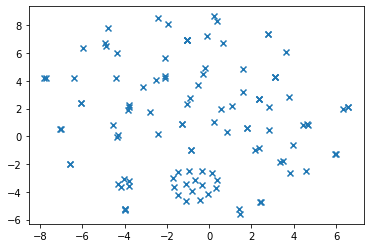

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn import manifold

from mpl_toolkits.mplot3d import Axes3D

# TODO: Add treshold

sim_matrix = np.around(cosine_similarity(tfidf), decimals=8)
dist_matrix = np.subtract(np.ones(sim_matrix.shape,  dtype=np.int8), sim_matrix) # sim <=> 1 - dist

X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(tfidf)
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_reduced)
#%%
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker="x")

In [8]:
from sklearn.cluster import DBSCAN

db = DBSCAN(min_samples=2, metric="precomputed", eps=0.05).fit(dist_matrix)
labels = db.labels_ # -1 = noise
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels) 

labels

array([ 0,  1,  2, -1,  3,  4, -1, -1,  2, -1, -1, -1,  5, -1,  4, -1,  2,
        6, -1, -1,  2,  7, -1, -1,  8,  7, -1, -1, -1,  2,  2, -1,  2, -1,
        0, -1,  2, -1, -1, -1, -1, -1,  8, -1,  9,  6, -1, -1,  4, -1, -1,
       -1,  3,  6, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1,  2,  0, -1,
       -1, -1, -1, -1, -1, -1,  1, -1,  2, -1, -1, -1, -1,  2, -1,  9, 10,
       -1,  2, -1, -1, -1,  2,  3,  2, -1, -1,  2, -1,  7, -1, -1, -1,  5,
        4, -1, -1, -1, 10,  4,  2, -1])

In [9]:
def create_clusters(labels):
    clusters = {}
    for i, c in enumerate(labels):
        if c == -1: continue
        if not c in clusters.keys():
            clusters[c] = [i]
        else:
            clusters[c].append(i)
    return clusters

clusters = create_clusters(labels)

In [10]:
clusters

{0: [0, 34, 56, 66],
 1: [1, 74],
 2: [2, 8, 16, 20, 29, 30, 32, 36, 65, 76, 81, 86, 90, 92, 95, 108],
 3: [4, 52, 91],
 4: [5, 14, 48, 102, 107],
 5: [12, 101],
 6: [17, 45, 53],
 7: [21, 25, 97],
 8: [24, 42],
 9: [44, 83],
 10: [84, 106]}

## The same model modified for the API

In [26]:
sum([r[0] for r in res])

80

In [31]:
counts

{'summa': 80, 'for': 1}

In [36]:
exid = "3c79c115-0f5f-4d8e-b02c-b4b33155a4b3"
len(exid)

36

In [139]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn import manifold
from sklearn.cluster import DBSCAN

import antlr4
from antlr4 import RuleContext

from antlr_local.JavaLexer import JavaLexer
from antlr_local.JavaParser import JavaParser
from antlr_local.JavaParserListener import JavaParserListener
from MyListener import KeyPrinter

import os
import json
import re
import glob
import pprint

def parse_testdata(path='../data/rainfall-submissions.tsv'):
    file = open(path,'r')
    raw = file.readlines()
    file.close()
    res = dict()
    exid = "3c79c115-0f5f-4d8e-b02c-b4b33155a4b3"
    get_code = lambda data: data["mooc-2017-ohjelmointi"]["osa02-Osa02_16.MarsinLampotilanKeskiarvo"]["/src/MarsinLampotilanKeskiarvo.java"]
    for line in raw:
        id = line[:len(exid)]
        body = json.loads(line[len(exid):])
        res[id] = get_code(body)
    return res

def normalize_for_ai(source_code):
    res = re.sub("\/\*.*\*\/", "", source_code, flags=re.DOTALL) # multiline comment
    res = re.sub("\/\/.*", "", res) # inline comments
    res = re.sub("\".+\"", "\"\"", res) # string values
    res = re.sub("\d+", "$", res)
    return res

def parse_to_compositional_tokens(code):
    #print("parsing: ", self.ID)
    code_stream = antlr4.InputStream(code)
    lexer = JavaLexer(code_stream)
    token_stream = antlr4.CommonTokenStream(lexer)
    parser = JavaParser(token_stream)
    tree = parser.compilationUnit()

    printer = KeyPrinter()
    walker = antlr4.ParseTreeWalker()
    walker.walk(printer, tree)

    return printer.get_result()

def parse_ast_tokens(codeList):
    n = len(codeList)
    token_list = [None] * n
    normalized_list = [None] * n
    for i, c in enumerate(codeList):
        token_list[i] = parse_to_compositional_tokens(c)
        normalized_list[i] = normalize_for_ai(c)
    return token_list, normalized_list

def create_clusters(labels):
    clusters = {}
    for i, c in enumerate(labels):
        if c == -1: continue
        if not c in clusters:
            clusters[c] = [i]
        else:
            clusters[c].append(i)
    return clusters

def run_ngram(codeList):
    # Hyper parameters
    ngrams = (3, 3)
    n_components = 50

    documents = len(codeList)
    tlist, nlist = parse_ast_tokens(codeList)
    df = pd.DataFrame({ "token_stream": tlist, "normalized": nlist })

    ngram_vectorizer = CountVectorizer(analyzer='word', 
                                       ngram_range=ngrams,
                                       token_pattern="[\S]+",
                                       lowercase=False,
                                       strip_accents="ascii")

    #transformer = TfidfTransformer(smooth_idf=True, norm=None)
    transformer = TfidfTransformer(smooth_idf=False)

    X = ngram_vectorizer.fit_transform(df.token_stream)
    tfidf = transformer.fit_transform(X)

    res_tf = pd.DataFrame(X.A, columns=ngram_vectorizer.get_feature_names())

    res_idf = pd.DataFrame(tfidf.A, columns=ngram_vectorizer.get_feature_names())

    sim_matrix = np.around(cosine_similarity(tfidf), decimals=8)
    dist_matrix = np.subtract(np.ones(sim_matrix.shape, dtype=np.int8), sim_matrix) # sim <=> 1 - dist

    X_reduced = TruncatedSVD(n_components=n_components, random_state=0).fit_transform(tfidf)
    X_embedded = TSNE(n_components=2, perplexity=40, verbose=0).fit_transform(X_reduced)

    db = DBSCAN(min_samples=2, metric="precomputed", eps=0.05).fit(dist_matrix)
    labels = db.labels_ # -1 = noise
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    unique_labels = set(labels) 

    labels_list = labels.tolist()
    clusters = create_clusters(labels_list)
    return {
        "clusters": clusters,
        "labels": labels_list,
        "params": {
            "ngrams": ngrams,
            "n_components": n_components,
        }
    }

def group_by_strings(codeDict, stringList):
    keys = codeDict.keys()
    n = len(keys)
    mat = np.zeros((n, len(stringList)))
    bool_to_int = lambda b: 1 if (b) else 0
    for i, k in enumerate(keys):
        mat[i] = np.array([1 if (s in codeDict[k]) else 0 for s in stringList])
    return {
        "ids": list(keys),
        "filters": stringList,
        "matches": mat,
        "counts": np.ones(n) @ mat,
        "score": np.sum(mat, axis=1) / len(stringList)
    }


In [140]:
import psycopg2
from dotenv import load_dotenv

import os
import json

load_dotenv()

POSTGRES_HOST = os.getenv("DB_HOST")
POSTGRES_PORT = os.getenv("DB_PORT")
POSTGRES_DB = os.getenv("DB_NAME")
POSTGRES_USER = os.getenv("DB_USER")
POSTGRES_PASSWORD = os.getenv("DB_PASSWORD")

conn = psycopg2.connect(host=POSTGRES_HOST, port=POSTGRES_PORT, database=POSTGRES_DB, user=POSTGRES_USER, password=POSTGRES_PASSWORD)

cur = conn.cursor()

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

def query_many(query):
    cur.execute(query)
    return cur.fetchall()

def cluster_submissions(courseId, exerciseId, wordFilters):
    rows = query_many(f"""SELECT id AS submission_id, code FROM submission WHERE course_id = {courseId} AND exercise_id = {exerciseId}""")
    codeList = [r[1] for r in rows]
    # print(codeList)
    ngram_result = run_ngram(codeList)
    filter_result = group_by_strings(dict(rows), wordFilters)
    return {
        "ngram": ngram_result,
        "filter": filter_result
    }


r = cluster_submissions(2, 1, ['Scanner', 'while', 'summa', ''])

In [142]:
r

{'ngram': {'clusters': {0: [0, 74, 77, 137, 150, 187],
   1: [1, 101, 151],
   2: [2, 76, 152],
   3: [3,
    4,
    12,
    14,
    15,
    16,
    19,
    24,
    51,
    78,
    80,
    111,
    124,
    139,
    144,
    145,
    155,
    169,
    172,
    178,
    182,
    201,
    203,
    207,
    210,
    211,
    218,
    228,
    235,
    243,
    250,
    251,
    256,
    259],
   4: [5, 39, 82, 189, 190, 195, 258],
   5: [6, 31, 36, 47, 75, 94, 128, 129, 186, 200, 231, 234],
   6: [7, 160, 254],
   7: [8, 81, 180],
   8: [9, 42, 46, 83, 105, 108, 109, 130, 181, 184, 219],
   9: [10, 20, 84, 110, 170, 202],
   10: [11, 92, 220],
   11: [13, 26, 99, 117, 162, 192, 255],
   12: [17, 119, 156],
   13: [18, 116, 191],
   14: [21, 133, 183],
   15: [22, 87, 204, 247],
   16: [23, 135, 242],
   17: [25, 91, 153, 245],
   18: [27, 103, 193],
   19: [28, 104, 173],
   20: [29, 88, 233],
   21: [30, 121, 175],
   22: [32, 131, 161],
   23: [33, 79, 239],
   24: [34, 93, 154],
   25:

In [143]:
rr = json.dumps(r, cls=NumpyEncoder)

In [128]:
rr

'{"filter": {"ids": [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 24, 26, 29, 33, 35, 38, 45, 16, 22, 31, 41, 50, 60, 70, 17, 25, 36, 47, 54, 62, 72, 18, 19, 28, 34, 40, 44, 56, 57, 67, 69, 20, 27, 37, 48, 55, 61, 75, 21, 30, 42, 51, 63, 71, 23, 32, 39, 43, 53, 66, 77, 46, 58, 68, 78, 49, 59, 65, 76, 52, 64, 74, 73, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 99, 112, 122, 132, 142, 154, 91, 98, 103, 113, 124, 134, 141, 148, 251, 260, 92, 102, 110, 119, 127, 137, 147, 256, 93, 106, 116, 128, 139, 151, 257, 94, 104, 114, 121, 130, 138, 149, 259, 95, 105, 115, 125, 136, 146, 262, 96, 107, 118, 126, 135, 145, 153, 97, 108, 120, 129, 140, 150, 101, 111, 123, 133, 143, 152, 155, 156, 157, 167, 177, 187, 196, 201, 211, 218, 158, 170, 180, 190, 200, 208, 215, 225, 236, 250, 160, 172, 183, 195, 203, 213, 223, 232, 240, 249, 159, 169, 185, 192, 202, 212, 221, 230, 239, 248, 161, 168, 176, 186, 197, 205, 209, 216, 224, 233, 162, 171, 181, 191, 199, 214, 227, 238, 247, 254, 163, 175, 182, 193, 206, 219

In [96]:
mat = r['filter']['matches']
v = np.ones(len(mat))
v @ mat

array([260., 260., 182., 260.])

In [110]:
mat.T @ v

array([260., 260., 182., 260.])

In [113]:
np.sum(mat, axis=1) / 4

array([1.  , 0.75, 0.75, 0.75, 1.  , 1.  , 1.  , 1.  , 0.75, 0.75, 1.  ,
       1.  , 0.75, 0.75, 1.  , 0.75, 1.  , 0.75, 1.  , 0.75, 1.  , 0.75,
       1.  , 0.75, 1.  , 1.  , 1.  , 1.  , 1.  , 0.75, 0.75, 1.  , 1.  ,
       0.75, 0.75, 1.  , 1.  , 0.75, 0.75, 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.75, 0.75,
       0.75, 1.  , 1.  , 0.75, 1.  , 1.  , 0.75, 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 0.75, 1.  , 1.  , 1.  , 1.  , 1.  , 0.75,
       1.  , 0.75, 0.75, 1.  , 0.75, 1.  , 0.75, 1.  , 0.75, 1.  , 1.  ,
       0.75, 1.  , 1.  , 1.  , 1.  , 0.75, 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 0.75, 1.  , 1.  , 1.  , 1.  , 0.75, 0.75, 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 0.75, 1.  , 0.75, 1.  , 0.75, 1.  ,
       0.75, 1.  , 1.  , 0.75, 1.  , 1.  , 0.75, 1.  , 1.  , 1.  , 1.  ,
       1.  , 0.75, 1.  , 0.75, 1.  , 1.  , 1.  , 1.  , 0.75, 0.75, 1.  ,
       1.  , 0.75, 1.  , 1.  , 1.  , 1.  , 0.75, 1.

In [111]:
x = np.ones((len(mat), 4))
mat @ x

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 260 is different from 4)

In [98]:
np.dot(v, mat)

array([260., 260., 182., 260.])

In [66]:
dict(rows)

{1: "#include <stdio.h>\nvoid main() {\n  printf('Hello There');\n}",
 2: "#include <stdio.h>\nint main() {\n  printf('Hello There');\n  return 0;\n}",
 3: '\nimport java.util.Scanner;\n\npublic class MarsinLampotilanKeskiarvo {\n\n    public static void main(String[] args) {\n        Scanner lukija = new Scanner(System.in);\n        \n        int summa = 0;\n        int syotteet = 0;\n        \n        while (true) {\n            System.out.print("Syötä luku: ");\n            int syote = Integer.parseInt(lukija.nextLine());\n            \n            if (syote == 9999) {\n                break;\n            } else if (syote <= 20 && syote >= -140) {\n                summa += syote;\n                syotteet++;\n            }\n        }\n        \n        System.out.println("Mittausten keskiarvo: " \n                            + (double) summa / syotteet );\n    }\n}\n',
 4: '\nimport java.util.Scanner;\n\npublic class MarsinLampotilanKeskiarvo {\n\n    public static void main(String[

In [61]:
r['filter']

([[False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,
   False,


In [ ]:
courseId = 1
exerciseId = 1
rows = query_many(f"""SELECT id AS submission_id, code FROM submission WHERE course_id = {courseId} AND exercise_id = {exerciseId}""")
codeList = [r[1] for r in rows]
codeList

In [40]:
rain = parse_testdata()

clusters, l = run_ngram(rain.values())
clusters

{0: [0, 34, 56, 66],
 1: [1, 74],
 2: [2, 8, 16, 20, 29, 30, 32, 36, 65, 76, 81, 86, 90, 92, 95, 108],
 3: [4, 52, 91],
 4: [5, 14, 48, 102, 107],
 5: [9, 27],
 6: [12, 101],
 7: [17, 45, 53],
 8: [21, 25, 97],
 9: [24, 42],
 10: [33, 38],
 11: [44, 83],
 12: [84, 106],
 13: [93, 105]}

In [35]:
l

array([ 0,  1,  2, -1,  3,  4, -1, -1,  2,  5, -1, -1,  6, -1,  4, -1,  2,
        7, -1, -1,  2,  8, -1, -1,  9,  8, -1,  5, -1,  2,  2, -1,  2, 10,
        0, -1,  2, -1, 10, -1, -1, -1,  9, -1, 11,  7, -1, -1,  4, -1, -1,
       -1,  3,  7, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1,  2,  0, -1,
       -1, -1, -1, -1, -1, -1,  1, -1,  2, -1, -1, -1, -1,  2, -1, 11, 12,
       -1,  2, -1, -1, -1,  2,  3,  2, 13, -1,  2, -1,  8, -1, -1, -1,  6,
        4, -1, -1, 13, 12,  4,  2, -1])

In [34]:
matches, counts = group_by_strings(['summa', 'for'], list(rain.values()))


In [17]:
l

array([ 0,  1,  2, -1,  3,  4, -1, -1,  2,  5, -1, -1,  6, -1,  4, -1,  2,
        7, -1, -1,  2,  8, -1, -1,  9,  8, -1,  5, -1,  2,  2, -1,  2, 10,
        0, -1,  2, -1, 10, -1, -1, -1,  9, -1, 11,  7, -1, -1,  4, -1, -1,
       -1,  3,  7, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1,  2,  0, -1,
       -1, -1, -1, -1, -1, -1,  1, -1,  2, -1, -1, -1, -1,  2, -1, 11, 12,
       -1,  2, -1, -1, -1,  2,  3,  2, 13, -1,  2, -1,  8, -1, -1, -1,  6,
        4, -1, -1, 13, 12,  4,  2, -1])

In [13]:
sum([len(clusters[k]) for k in clusters])

50

In [11]:
len(clusters.keys())

14

In [5]:
clusters

{0: [0, 34, 56, 66],
 1: [1, 74],
 2: [2, 8, 16, 20, 29, 30, 32, 36, 65, 76, 81, 86, 90, 92, 95, 108],
 3: [4, 52, 91],
 4: [5, 14, 48, 102, 107],
 5: [12, 101],
 6: [17, 45, 53],
 7: [21, 25, 97],
 8: [24, 42],
 9: [44, 83],
 10: [84, 106]}

In [2]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker="x")

clusters

NameError: name 'plt' is not defined